# 02 - Model Evaluation
Compute AUROC and visualize performance metrics.

In [1]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm

# Add src to path
sys.path.append('..')
from src.models.resnet1d import resnet1d50
from src.data.dataset import PTBXLDataset
from src.train import load_metadata

In [2]:
# 1. Load Model & Data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

# Load Model
model = resnet1d50(num_classes=5)
# Try to load weights
weights_path = '../src/models/resnet1d_best.pth'
if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path, map_location=device))
    print("Loaded best weights.")
else:
    print("WARNING: No weights found. Model is untrained. Please run train.py first.")

model.to(device)
model.eval()

# Load Validation Data (Fold 1)
DATA_DIR = '../data/ptb-xl'
if os.path.exists(os.path.join(DATA_DIR, 'ptbxl_database.csv')):
    df = load_metadata(DATA_DIR)
    # Standard Stratified Split Re-creation (Must match train.py logic)
    from sklearn.model_selection import StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)
    splits = list(sgkf.split(df.index, df['strat_target'], df['patient_id']))
    _, val_idx = splits[0]
    val_df = df.iloc[val_idx]

    val_ds = PTBXLDataset(val_df, DATA_DIR, sampling_rate=500, use_ram_cache=True)
    print(f"Validation Set: {len(val_ds)} records")
else:
    print("Dataset not found.")

Using cuda
Loaded best weights.
Loading 2180 records into RAM (Samplng Rate: 500Hz)...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2180/2180 [00:11<00:00, 182.70it/s]

Validation Set: 2180 records


In [3]:
# 2. Run Inference
if 'val_ds' in locals():
    loader = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device)
            logits = model(x)
            probs = torch.sigmoid(logits)
            all_preds.append(probs.cpu().numpy())
            all_targets.append(y.numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    print("Inference Complete.")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 23.02it/s]

Inference Complete.


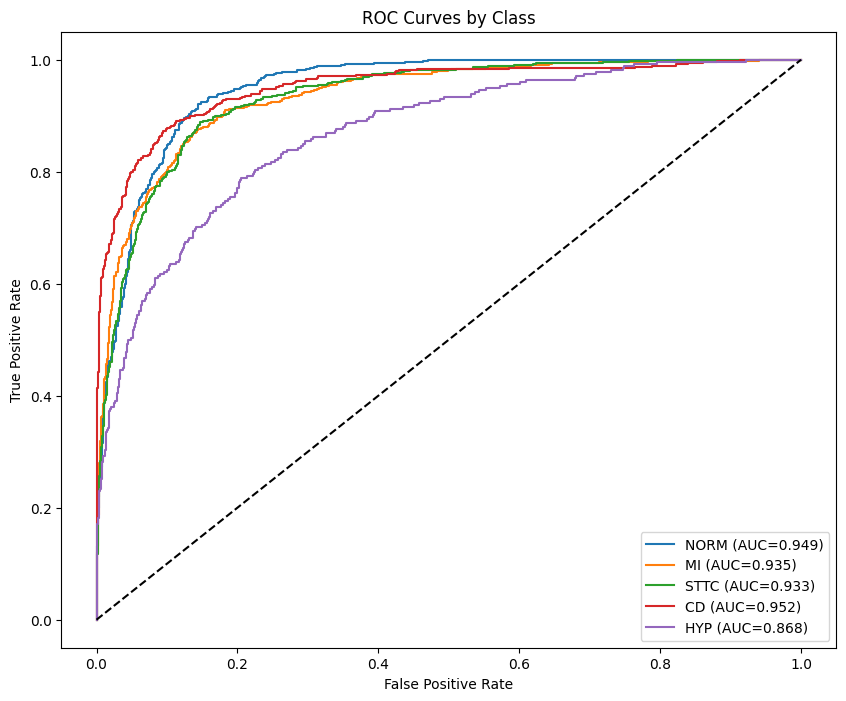

In [4]:
# 3. ROC Curves
classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

if 'all_preds' in locals():
    plt.figure(figsize=(10, 8))
    for i, cls in enumerate(classes):
        try:
            auc = roc_auc_score(all_targets[:, i], all_preds[:, i])
            fpr, tpr, _ = roc_curve(all_targets[:, i], all_preds[:, i])
            plt.plot(fpr, tpr, label=f"{cls} (AUC={auc:.3f})")
        except:
            print(f"Could not calc AUC for {cls} (maybe 0 samples in val set?)")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves by Class")
    plt.legend()
    plt.show()